In [0]:
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [4]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [5]:
!nvidia-smi

Mon May 25 07:39:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
classes = ('normal', 'opacity') 
path_train = '/content/drive/My Drive/hufs/RSNA2019/1500/'
path_valid = '/content/drive/My Drive/hufs/RSNA2019/100/'
batch_size = 100

In [0]:
trainset = torchvision.datasets.ImageFolder(root = path_train,transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                                          transforms.Resize((256,256)),
                                                                                          transforms.ToTensor()]))
validset = torchvision.datasets.ImageFolder(root = path_valid,transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                                          transforms.Resize((256,256)),
                                                                                          transforms.ToTensor()]))
train_iter = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
valid_iter = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=True)

In [8]:
tgtnames = trainset.classes
tgtnames

['normal', 'opacity']

torch.Size([100])
torch.Size([100, 1, 256, 256])


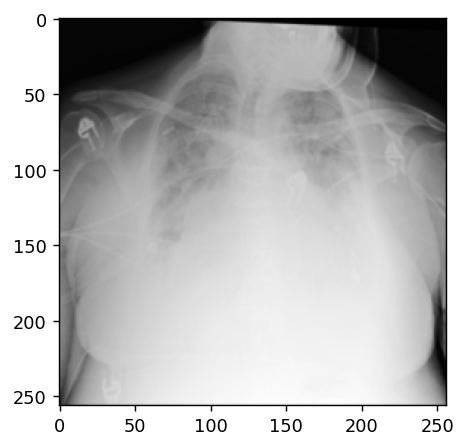

tensor(1)
opacity


In [9]:
dataiter=iter(train_iter)
images, labels = dataiter.next()
print(labels.shape)
print(images.shape)
I = images[0][0].numpy()
plt.figure(dpi=128)
plt.imshow(I,cmap='gray')
plt.show()
print(labels[0])
print(tgtnames[labels[0]])


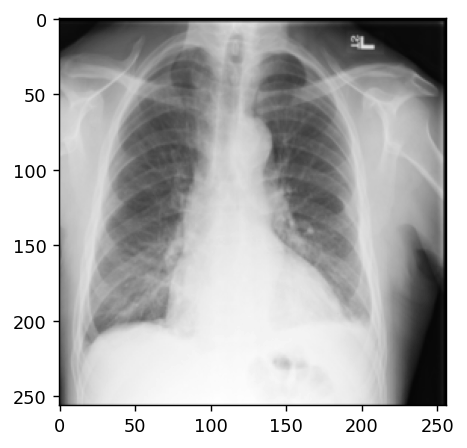

opacity


In [10]:
n=2
I = images[n][0].numpy()
plt.figure(dpi=128)
plt.imshow(I,cmap='gray')
plt.show()
print(tgtnames[labels[n]])


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [0]:
# setting hyper-parameters
learning_rate = 0.02
num_epochs = 30
num_workers = 0

# LeNet5

- LeNet을 아래와 같은 코드로 구현하였습니다. sigmoid를 relu로 바꾼 것을 제외하고는 orignial lenet과 거의 같습니다.

In [13]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
    
net = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.ReLU(), 
    nn.AvgPool2d(kernel_size=2, stride=2), 

    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding = 0),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),

    Flatten(),

    nn.Linear(in_features=16*(62)*(62), out_features=120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 2) # 0: normal, 1: abnormal
)
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten()
  (7): Linear(in_features=61504, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=2, bias=True)
)

- parameter들에 대한 initialization을 수행해 봅니다.

In [14]:
torch.nn.init.xavier_uniform_(net[0].weight)
torch.nn.init.xavier_uniform_(net[3].weight)
torch.nn.init.xavier_uniform_(net[7].weight)
torch.nn.init.xavier_uniform_(net[9].weight)
torch.nn.init.xavier_uniform_(net[11].weight)
net = net.to(device) # GPU 
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten()
  (7): Linear(in_features=61504, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=2, bias=True)
)

In [0]:
# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(net.parameters(),lr=learning_rate) # sgd

- train loss, train accuracy, valid accuracy를 관찰하면서 학습을 진행합니다.

tensor([[ 0.0771,  0.1357],
        [ 0.1485,  0.1167],
        [ 0.0077,  0.2998],
        [ 0.2413, -0.0292]], device='cuda:0', grad_fn=<SliceBackward>)


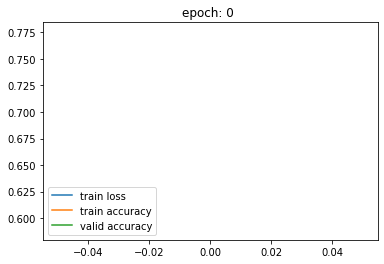

train loss:  0.6754414876302083
train accuracy:  0.5889999866485596
valid accuracy:  0.7749999761581421
tensor([[ 1.1950, -0.3621],
        [ 0.4846,  0.3395],
        [ 0.6262,  0.5662],
        [ 1.1155, -0.5498]], device='cuda:0', grad_fn=<SliceBackward>)


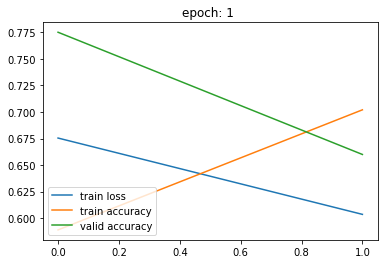

train loss:  0.6036321640014648
train accuracy:  0.7020000219345093
valid accuracy:  0.6600000262260437
tensor([[ 1.8954, -1.5093],
        [-0.7802,  2.5325],
        [ 0.3807,  0.7309],
        [-0.2543,  1.6103]], device='cuda:0', grad_fn=<SliceBackward>)


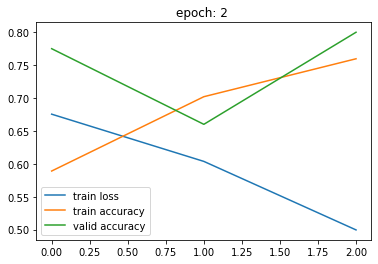

train loss:  0.49946091969807943
train accuracy:  0.7596666812896729
valid accuracy:  0.800000011920929
tensor([[ 0.1251,  0.6825],
        [ 1.2002, -0.7536],
        [ 1.5376, -1.2719],
        [ 0.1129,  0.9251]], device='cuda:0', grad_fn=<SliceBackward>)


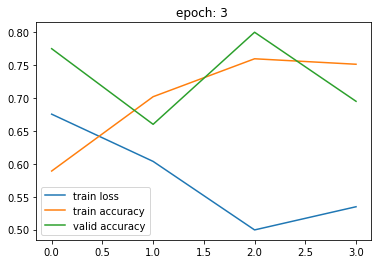

train loss:  0.5346972147623698
train accuracy:  0.7513333559036255
valid accuracy:  0.6949999928474426
tensor([[ 0.6445, -0.1414],
        [ 0.9076, -0.5992],
        [-0.4684,  1.7136],
        [ 0.6723, -0.3012]], device='cuda:0', grad_fn=<SliceBackward>)


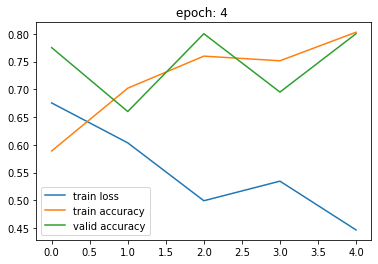

train loss:  0.4469546635945638
train accuracy:  0.8026666641235352
valid accuracy:  0.800000011920929
tensor([[ 0.6480, -0.4340],
        [-1.0190,  2.3786],
        [ 0.7327, -0.3634],
        [ 0.8070, -0.7224]], device='cuda:0', grad_fn=<SliceBackward>)


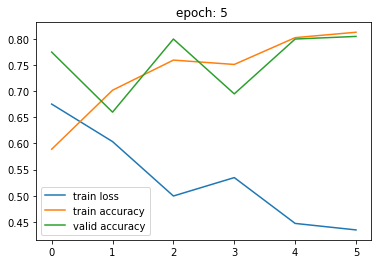

train loss:  0.4345175425211589
train accuracy:  0.8130000233650208
valid accuracy:  0.8050000071525574
tensor([[-0.6090,  1.7193],
        [ 1.1243, -0.8235],
        [ 1.8100, -1.7123],
        [ 0.5999, -0.3193]], device='cuda:0', grad_fn=<SliceBackward>)


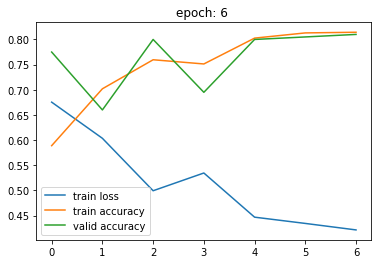

train loss:  0.421625010172526
train accuracy:  0.8143333196640015
valid accuracy:  0.8100000023841858
tensor([[-0.0706,  0.9797],
        [ 1.2347, -1.2512],
        [ 1.3334, -1.4255],
        [ 0.2847, -0.0452]], device='cuda:0', grad_fn=<SliceBackward>)


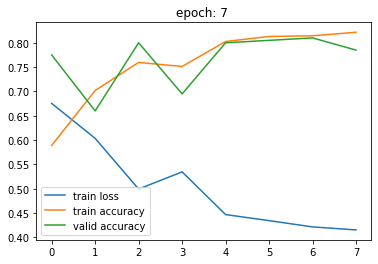

train loss:  0.4154436747233073
train accuracy:  0.8216666579246521
valid accuracy:  0.7850000262260437
tensor([[ 0.4842, -0.0023],
        [-0.1078,  0.8689],
        [ 0.2009,  0.5036],
        [ 0.0241,  0.5462]], device='cuda:0', grad_fn=<SliceBackward>)


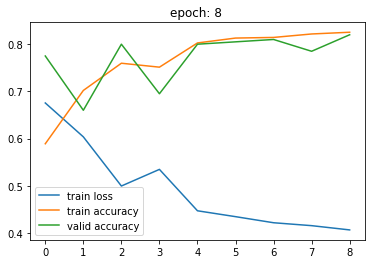

train loss:  0.4064165751139323
train accuracy:  0.8253333568572998
valid accuracy:  0.8199999928474426
tensor([[-3.1732e-01,  1.3819e+00],
        [-4.6612e-01,  1.3937e+00],
        [-1.0339e-03,  7.1290e-01],
        [ 5.4863e-01, -3.4948e-01]], device='cuda:0', grad_fn=<SliceBackward>)


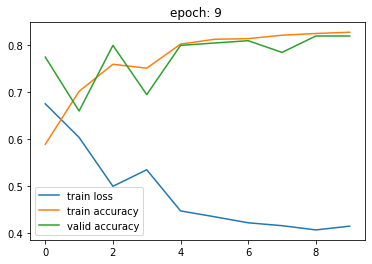

train loss:  0.41444873809814453
train accuracy:  0.828000009059906
valid accuracy:  0.8199999928474426
tensor([[-0.5967,  1.0943],
        [-1.0521,  2.1934],
        [ 1.9190, -1.9793],
        [-0.8089,  2.1584]], device='cuda:0', grad_fn=<SliceBackward>)


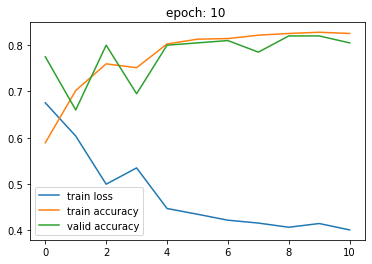

train loss:  0.40063711802164714
train accuracy:  0.8253333568572998
valid accuracy:  0.8050000071525574
tensor([[ 2.0429, -1.9364],
        [ 0.5284,  0.1363],
        [ 0.4144, -0.0536],
        [ 1.4027, -1.2373]], device='cuda:0', grad_fn=<SliceBackward>)


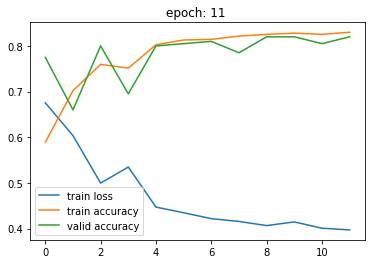

train loss:  0.39692490895589194
train accuracy:  0.8299999833106995
valid accuracy:  0.8199999928474426
tensor([[ 0.6851, -0.0881],
        [ 0.9094, -0.3812],
        [ 1.5757, -1.0697],
        [-0.8660,  1.7750]], device='cuda:0', grad_fn=<SliceBackward>)


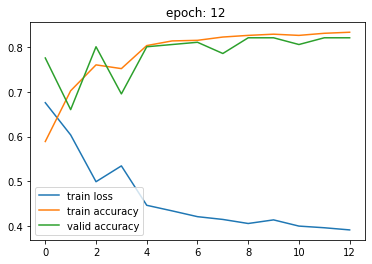

train loss:  0.39210888544718425
train accuracy:  0.8323333263397217
valid accuracy:  0.8199999928474426
tensor([[ 1.0482, -0.6461],
        [ 1.3373, -0.9058],
        [-0.0981,  1.1715],
        [-0.6761,  1.5771]], device='cuda:0', grad_fn=<SliceBackward>)


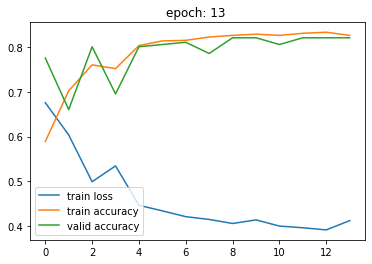

train loss:  0.4127589225769043
train accuracy:  0.8253333568572998
valid accuracy:  0.8199999928474426
tensor([[-0.7349,  1.9056],
        [ 0.4459, -0.2188],
        [-1.0970,  2.3646],
        [ 1.3157, -1.2651]], device='cuda:0', grad_fn=<SliceBackward>)


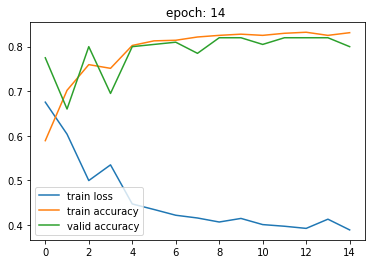

train loss:  0.3886789004007975
train accuracy:  0.831333339214325
valid accuracy:  0.800000011920929
tensor([[ 0.5884, -0.3683],
        [ 1.1980, -0.6856],
        [ 0.2357,  0.2587],
        [ 1.3316, -1.1150]], device='cuda:0', grad_fn=<SliceBackward>)


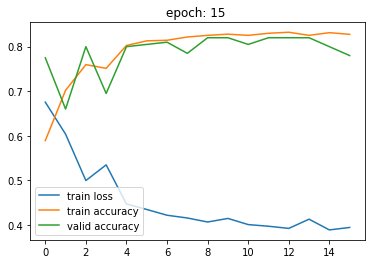

train loss:  0.3942104339599609
train accuracy:  0.8276666402816772
valid accuracy:  0.7799999713897705
tensor([[-0.6207,  1.4508],
        [ 1.2159, -0.7514],
        [ 0.3864,  0.8863],
        [ 1.4216, -0.8968]], device='cuda:0', grad_fn=<SliceBackward>)


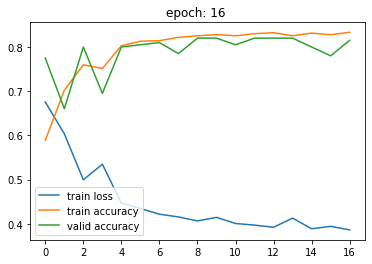

train loss:  0.3860731760660807
train accuracy:  0.8333333134651184
valid accuracy:  0.8149999976158142
tensor([[ 1.2194, -0.5790],
        [ 0.9932, -0.7867],
        [-0.1609,  1.3848],
        [-0.7578,  1.7707]], device='cuda:0', grad_fn=<SliceBackward>)


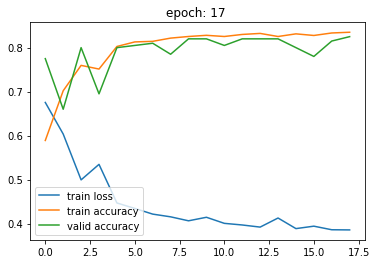

train loss:  0.38570442199707033
train accuracy:  0.8349999785423279
valid accuracy:  0.824999988079071
tensor([[-0.5016,  1.6736],
        [-0.0026,  0.8392],
        [-0.9001,  1.9040],
        [ 1.6621, -1.7334]], device='cuda:0', grad_fn=<SliceBackward>)


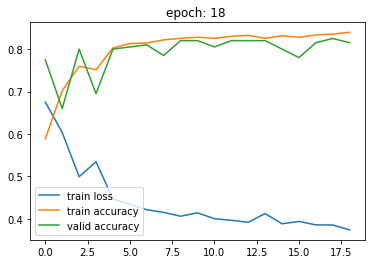

train loss:  0.37421318689982097
train accuracy:  0.8396666646003723
valid accuracy:  0.8149999976158142
tensor([[-0.0848,  0.6343],
        [ 0.9290, -0.8290],
        [ 0.7872, -0.5981],
        [-0.9303,  1.8732]], device='cuda:0', grad_fn=<SliceBackward>)


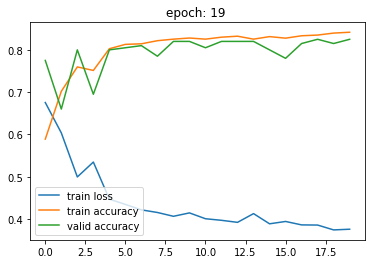

train loss:  0.3758641242980957
train accuracy:  0.8416666388511658
valid accuracy:  0.824999988079071
tensor([[ 1.6105, -1.4468],
        [-0.4310,  1.0868],
        [-0.8997,  1.8763],
        [ 0.8731, -0.6697]], device='cuda:0', grad_fn=<SliceBackward>)


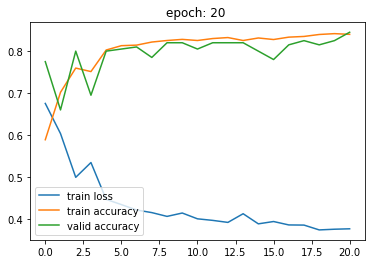

train loss:  0.3768791198730469
train accuracy:  0.8399999737739563
valid accuracy:  0.8450000286102295
tensor([[ 0.0732,  0.8339],
        [ 1.2322, -1.0322],
        [ 1.0672, -0.6604],
        [-0.8597,  2.5509]], device='cuda:0', grad_fn=<SliceBackward>)


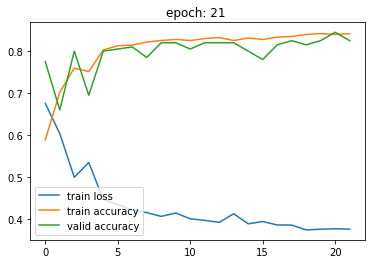

train loss:  0.37592948277791344
train accuracy:  0.8413333296775818
valid accuracy:  0.824999988079071
tensor([[-0.5834,  1.8133],
        [ 1.3139,  0.1542],
        [ 0.6632, -0.3406],
        [-0.7832,  1.2922]], device='cuda:0', grad_fn=<SliceBackward>)


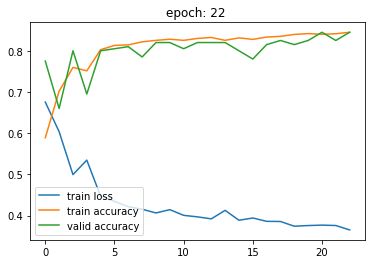

train loss:  0.36524775822957356
train accuracy:  0.8450000286102295
valid accuracy:  0.8450000286102295
tensor([[ 0.5393, -0.0839],
        [ 1.6511, -2.0250],
        [-1.0302,  1.9166],
        [-1.7227,  2.9971]], device='cuda:0', grad_fn=<SliceBackward>)


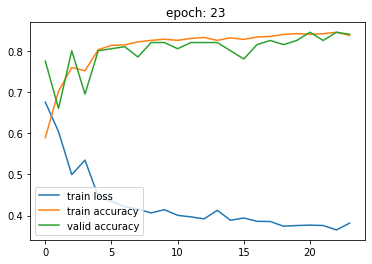

train loss:  0.3817525227864583
train accuracy:  0.8373333215713501
valid accuracy:  0.8399999737739563
tensor([[ 0.2041, -0.0500],
        [-1.2378,  2.3184],
        [-0.2335,  1.0976],
        [ 0.5669, -0.3433]], device='cuda:0', grad_fn=<SliceBackward>)


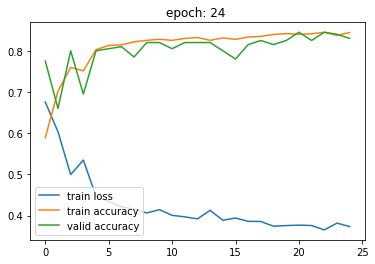

train loss:  0.37334798177083334
train accuracy:  0.8443333506584167
valid accuracy:  0.8299999833106995
tensor([[ 1.4644, -0.7615],
        [-1.1548,  2.6316],
        [ 1.8119, -1.5409],
        [-0.5225,  1.5235]], device='cuda:0', grad_fn=<SliceBackward>)


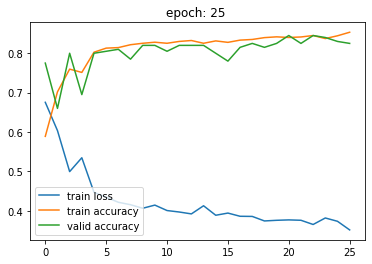

train loss:  0.35144500732421874
train accuracy:  0.8533333539962769
valid accuracy:  0.824999988079071
tensor([[ 1.2906, -1.0602],
        [ 0.2157,  1.0572],
        [-0.7132,  1.6177],
        [ 1.8892, -1.1976]], device='cuda:0', grad_fn=<SliceBackward>)


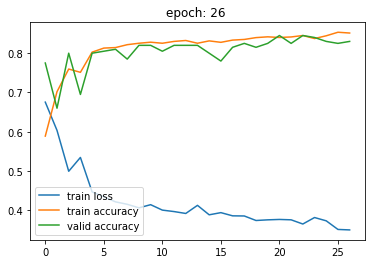

train loss:  0.35022977193196614
train accuracy:  0.8513333201408386
valid accuracy:  0.8299999833106995
tensor([[-0.9990,  1.6295],
        [ 0.7650, -0.6704],
        [ 2.0481, -2.0614],
        [ 0.9892, -0.2266]], device='cuda:0', grad_fn=<SliceBackward>)


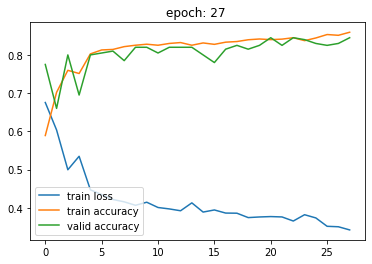

train loss:  0.34197206497192384
train accuracy:  0.859333336353302
valid accuracy:  0.8450000286102295
tensor([[-0.1397,  0.7785],
        [-0.3034,  1.9063],
        [-0.6455,  1.5562],
        [-0.6335,  1.5585]], device='cuda:0', grad_fn=<SliceBackward>)


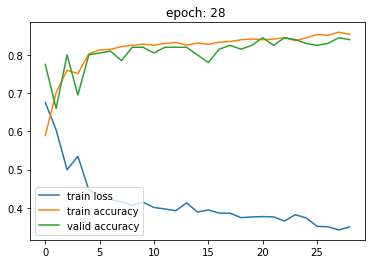

train loss:  0.349801508585612
train accuracy:  0.8539999723434448
valid accuracy:  0.8399999737739563
tensor([[ 0.9200,  0.7278],
        [-0.7051,  1.7466],
        [ 1.4977, -0.8883],
        [-0.0768,  0.7679]], device='cuda:0', grad_fn=<SliceBackward>)


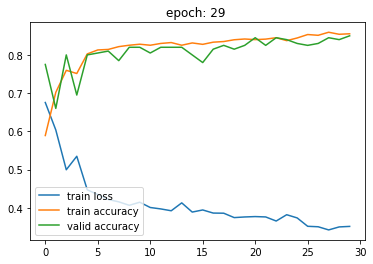

train loss:  0.3511749903361003
train accuracy:  0.8553333282470703
valid accuracy:  0.8500000238418579


In [16]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X,y = X.to(device),y.to(device) # GPU 
    y_hat=net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,correct.cpu()/3000.)

  correct = 0
  for X,y in valid_iter:
    X,y = X.to(device),y.to(device)
    y_hat = net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()

  print((y_hat[:4]))
  accs_valid = np.append(accs_valid,correct.cpu()/200.)


  if epoch%4 > -1:
    plt.plot(loss_train,label='train loss')
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)

    print('train loss: ',loss_train[-1])
    print('train accuracy: ',accs_train[-1])
    print('valid accuracy: ',accs_valid[-1])

In [ ]:
torch.save(net.state_dict(),'/content/drive/My Drive/hufs/RSNA2019/lenet5_rsna2019_256x256_v20200525')

# Validation
- 학습이 완료된 모델에 대해 결과를 실제 영상과 함께 관찰합니다.

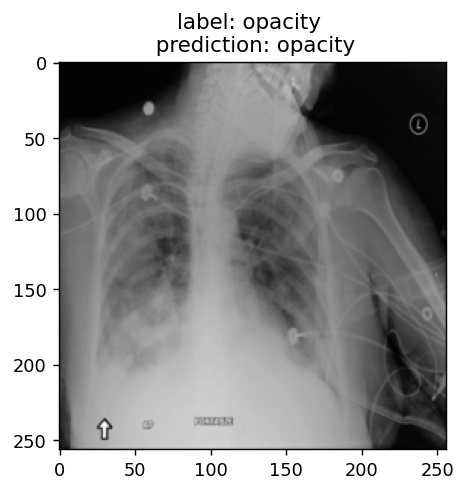

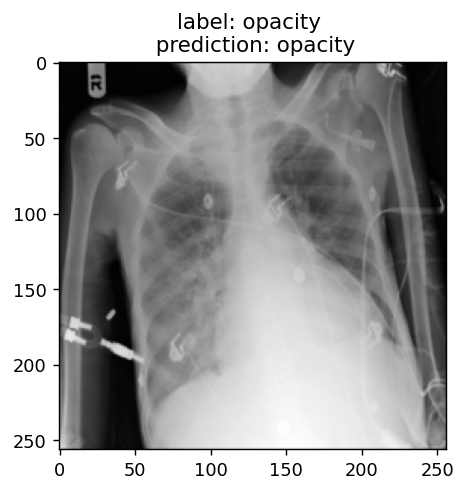

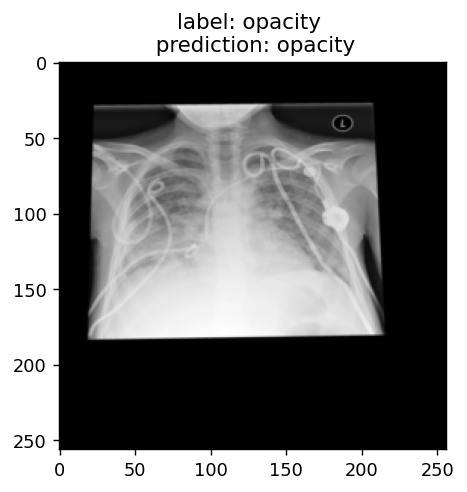

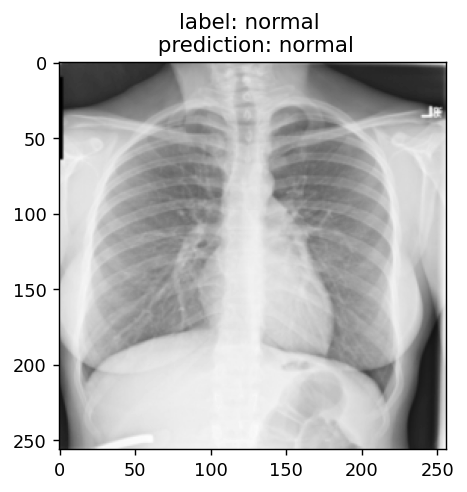

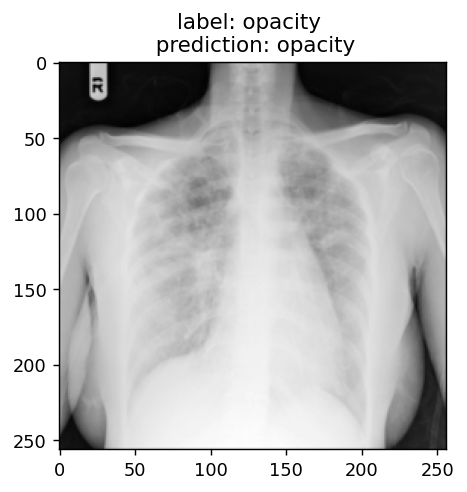

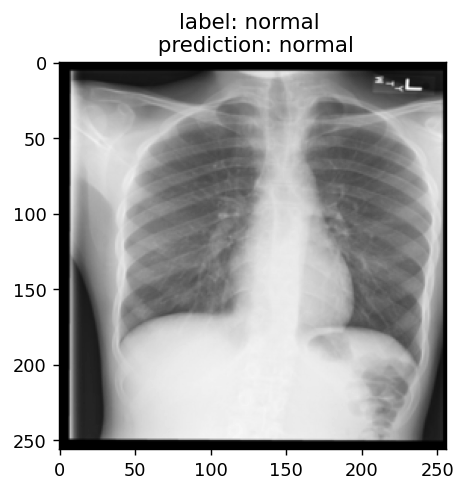

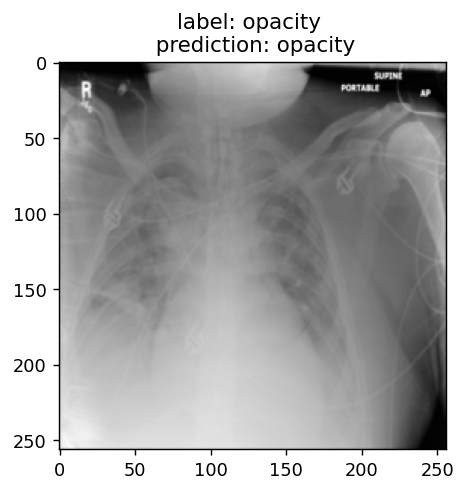

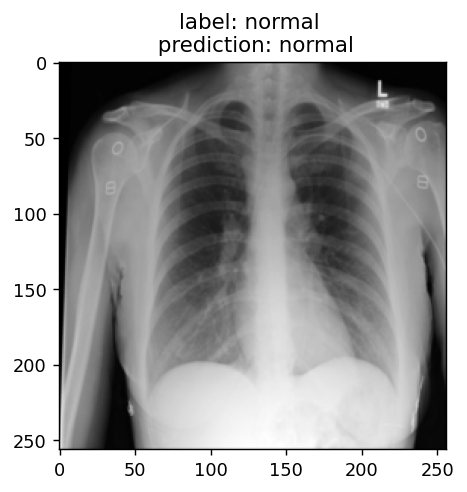

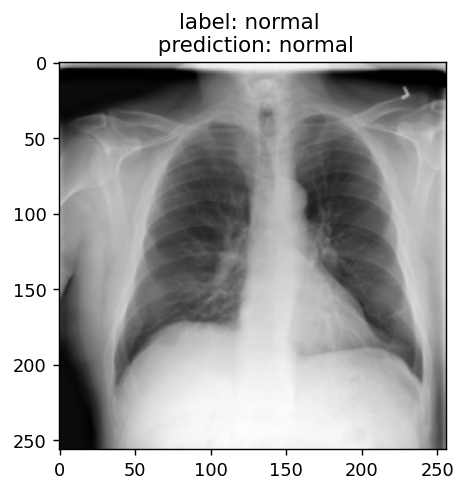

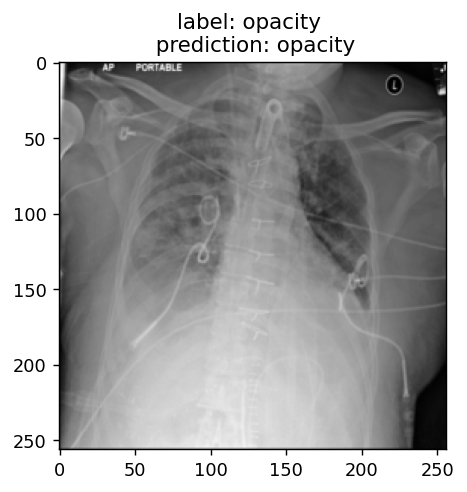

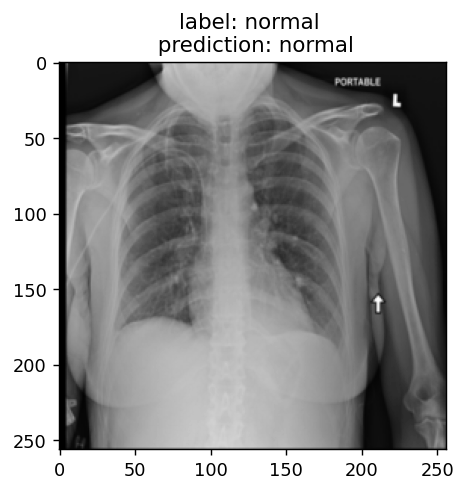

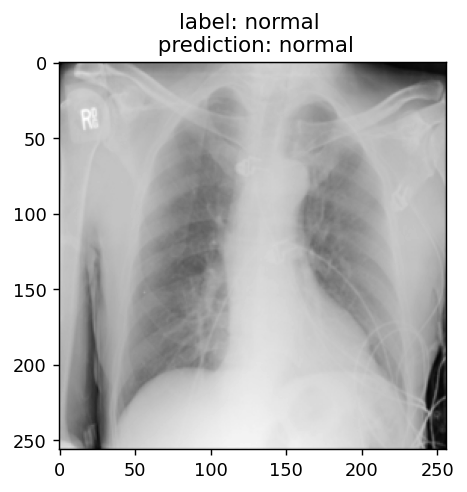

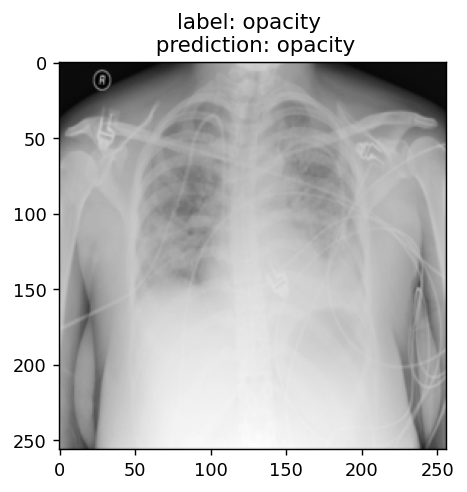

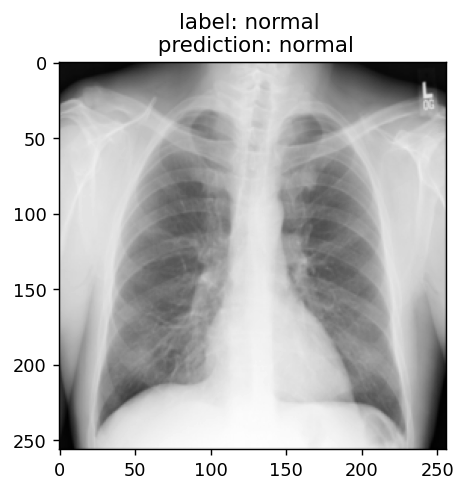

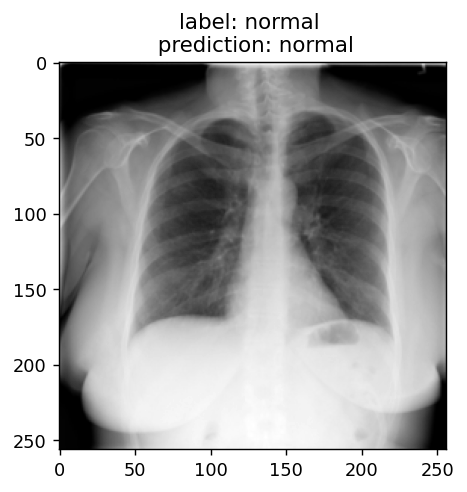

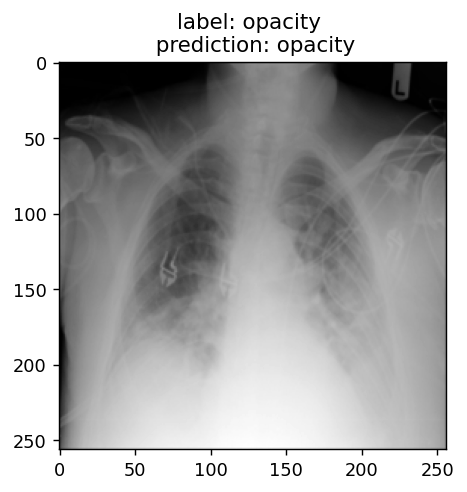

In [23]:
i = 0
for X,y in valid_iter:
  i=i+1
  X=X.to(device)
  y_hat = net(X)    
  y_hat = y_hat.argmax(dim=1)
  for n in range(8):
    plt.figure(dpi=128)
    plt.imshow(X[n].cpu().squeeze(),cmap='gray')
    plt.title('label: %s \n prediction: %s'%(tgtnames[y[n]],tgtnames[y_hat[n]]))
    plt.pause(.0001)
  if i>2:
     break

- 임의의 데이터에 대해 예측을 해보도록 합시다.


In [0]:
from PIL import Image

In [0]:
transform=transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize((256,256)), transforms.ToTensor()])

- imgurl에 경로복사를 이용해 테스트해볼 파일의 경로를 가져옵니다.

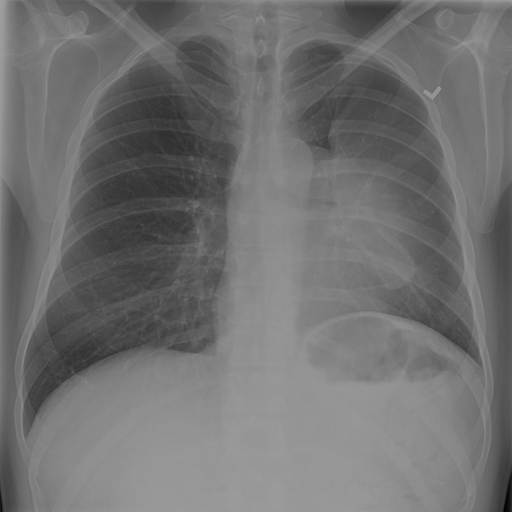

In [20]:
imgurl = '/content/drive/My Drive/hufs/RSNA2019/100/opacity/0a578f72-dced-4550-8851-d8005549b724.png'
img = Image.open(imgurl)
img

- 모델을 만들 때에 사용한 transform과 같은 transform이 행해져야하는 것에 유의합시다. 
- prediction의 결과가 실제 데이터의 정답과 맞는 지 확인합니다.

tensor([1], device='cuda:0', grad_fn=<NotImplemented>)


Text(0.5, 1.0, 'prediction: opacity')

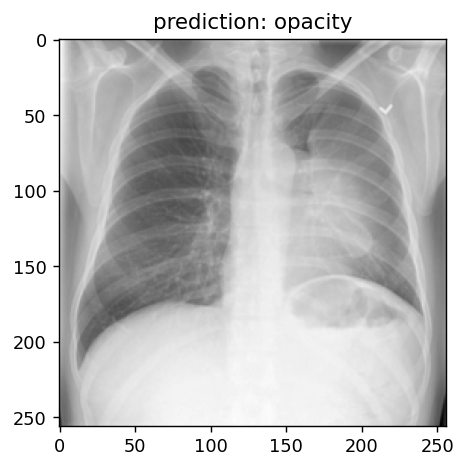

In [21]:
imgt = transform(img).float().unsqueeze(0)
imgt.shape
pred = net(imgt.to(device))
print(pred.argmax(dim=1))
plt.figure(dpi=128)
plt.imshow(imgt.cpu().squeeze(),cmap='gray')
plt.title('prediction: %s'%(tgtnames[pred.argmax(dim=1)]))